In [1]:
import math
import numpy as np

# Value class starter code, with many functions taken out
from math import exp, log
import matplotlib.pyplot as plt
%matplotlib inline


from graphviz import Digraph

def trace(root):
    nodes, edges = set(), set()
    def build(v):
        if v not in nodes:
            nodes.add(v)
            for child in v._prev:
                edges.add((child, v))
                build(child)
    build(root)
    return nodes, edges

def draw_dot(root, format='svg', rankdir='LR'):
    """
    format: png | svg | ...
    rankdir: TB (top to bottom graph) | LR (left to right)
    """
    assert rankdir in ['LR', 'TB']
    nodes, edges = trace(root)
    dot = Digraph(format=format, graph_attr={'rankdir': rankdir}) #, node_attr={'rankdir': 'TB'})

    for n in nodes:
        dot.node(name=str(id(n)), label = "{ %s | data %.4f | grad %.4f }" % (n.label, n.data, n.grad), shape='record')
        if n._op:
            dot.node(name=str(id(n)) + n._op, label=n._op)
            dot.edge(str(id(n)) + n._op, str(id(n)))

    for n1, n2 in edges:
        dot.edge(str(id(n1)), str(id(n2)) + n2._op)

    return dot

In [2]:

class Value:

  def __init__(self, data, _children=(), _op='', label=''):
    self.data = data
    self.grad = 0.0
    self._backward = lambda: None
    self._prev = set(_children)
    self._op = _op
    self.label = label

  def __repr__(self):
    return f"Value(data={self.data})"

  def __add__(self, other): # exactly as in the video
    other = other if isinstance(other, Value) else Value(other)
    out = Value(self.data + other.data, (self, other), '+')

    def _backward():
      self.grad += 1.0 * out.grad
      other.grad += 1.0 * out.grad
    out._backward = _backward

    return out

  def __neg__(self): # -self
      return self * -1

  def __radd__(self, other): # other + self
        return self + other

  def __rsub__(self, other): # other - self
      return other + (-self)

  def __sub__(self, other): # self - other
      return self + (-other)

  def __truediv__(self, other): # self / other
      return self * other**-1

  def __rtruediv__(self, other): # other / self
      return other * self**-1

  def __pow__(self, other):
      assert isinstance(other, (int, float)), "only supporting int/float powers for now"
      out = Value(self.data**other, (self,), f'pow({other})')

      def _backward():
          self.grad += (other * self.data**(other-1)) * out.grad
      out._backward = _backward

      return out

  def __mul__(self, other):
      other = other if isinstance(other, Value) else Value(other)
      out = Value(self.data * other.data, (self, other), '*')

      def _backward():
          self.grad += other.data * out.grad
          other.grad += self.data * out.grad
      out._backward = _backward

      return out

  def exp(self):
    out = Value(exp(self.data), (self, ), 'exp')

    def _backward():
      self.grad += exp(self.data) * out.grad
    out._backward = _backward

    return out

  def log(self):
    out = Value(log(self.data), (self, ), 'log')

    def _backward():
      self.grad += (1 / self.data) * out.grad
    out._backward = _backward

    return out

  def backward(self): # exactly as in video
    topo = []
    visited = set()
    def build_topo(v):
      if v not in visited:
        visited.add(v)
        for child in v._prev:
          build_topo(child)
        topo.append(v)
    build_topo(self)

    self.grad = 1.0
    for node in reversed(topo):
      node._backward()

In [3]:
# without referencing our code/video __too__ much, make this cell work
# you'll have to implement (in some cases re-implemented) a number of functions
# of the Value object, similar to what we've seen in the video.
# instead of the squared error loss this implements the negative log likelihood
# loss, which is very often used in classification.

# this is the softmax function
# https://en.wikipedia.org/wiki/Softmax_function
def softmax(logits):
  counts = [logit.exp() for logit in logits]
  denominator = sum(counts)
  out = [c / denominator for c in counts]
  return out

# this is the negative log likelihood loss function, pervasive in classification
logits2 = [Value(0.0), Value(3.0), Value(-2.0), Value(1.0)]
probs = softmax(logits2)
loss = -probs[3].log() # dim 3 acts as the label for this input example
loss.backward()
print(loss.data)

ans = [0.041772570515350445, 0.8390245074625319, 0.005653302662216329, -0.8864503806400986]
for dim in range(4):
  ok = 'OK' if abs(logits2[dim].grad - ans[dim]) < 1e-5 else 'WRONG!'
  print(f"{ok} for dim {dim}: expected {ans[dim]}, yours returns {logits2[dim].grad}")


2.1755153626167147
OK for dim 0: expected 0.041772570515350445, yours returns 0.041772570515350445
OK for dim 1: expected 0.8390245074625319, yours returns 0.8390245074625319
OK for dim 2: expected 0.005653302662216329, yours returns 0.005653302662216329
OK for dim 3: expected -0.8864503806400986, yours returns -0.8864503806400986


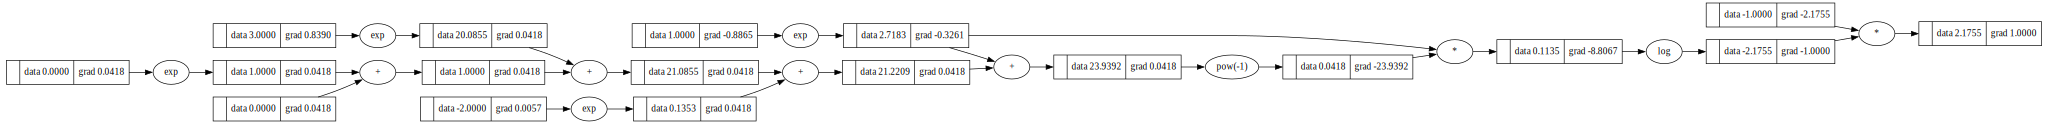

In [4]:
draw_dot(loss)

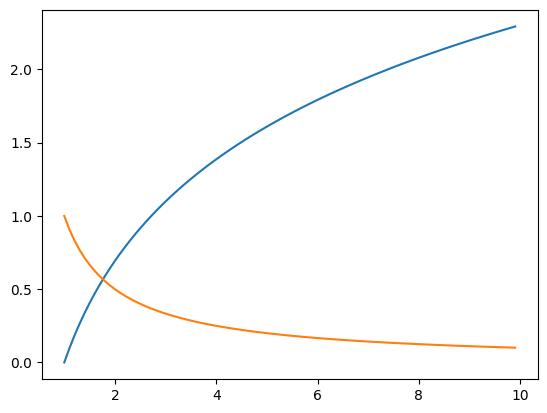

In [5]:
xs = np.arange(1, 10.0, 0.1)
logs = np.log(xs)
dlogs = (1 / xs)

plt.plot(xs,logs)
plt.plot(xs,dlogs)
